## Markov Chain Monte Carlo

Suppose we wish to draw samples from the posterior distribution
$$
p(x) = \int_\theta p(x|\theta) p (\theta) d \theta
$$
and that the computation of the normalization factor is intractable, due to the high dimensionality of the problem.

**Markov Chain Monte Carlo** is a sampling method which scales well will the dimensionality of the sample space. Instead of directly sampling from $p(x)$, we sample from a Markov chain whose stationary distribution equals $p(x)$. The longer the chains, the more closely the distribution of the sample matches the target distribution.

### Hamiltonian Monte Carlo



### Example
Let's go back to the example from notebook 02:

$$weight \, | \, guess \sim \mathcal{N}(guess, 1)$$

$$ measurement \, | \, guess, weight \sim \mathcal{N}(weight, 0.75^2) $$


In [3]:
import torch
import pyro
import pyro.distributions as dist
pyro.set_rng_seed(1)

# define model
def scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    measurement = pyro.sample("measurement", dist.Normal(weight, 0.75))
    return measurement

Suppose that we observe a measurement of the object corresponding to 14 kg. We want to sample from the distribution of the weight given both the observation and an input knowledge `guess = 8.5`. In other words, we wish to infer the distribution 

$$weight \, | \, guess, measurement=9.5 \sim ?$$

Pyro provides a method called `pyro.condition` that takes a model and a dictionary of observations and returns a new model which is fixed on the measurement observation.

In [4]:
# condition the model on a single observation
conditioned_scale = pyro.condition(scale, data={"measurement": torch.tensor(9.5)})

`conditioned_scale()` model could be equivalently defined as follows:

In [1]:
# using obs parameter
def conditioned_scale(guess): 
    weight = pyro.sample("weight", dist.Normal(guess, 1.))
    measurement = pyro.sample("measurement", dist.Normal(weight, 1.), obs=9.5)
    return measurement

Now that we have conditioned on an observation of measurement, we can perform inference.
This is an example of how you would write a posterior distribution on the conditioned scale model using MCMC.

In [28]:
from pyro.infer.mcmc import MCMC, HMC

hmc_kernel = HMC(model=conditioned_scale, step_size=0.9, num_steps=4)
mcmc = MCMC(hmc_kernel, num_samples=1000, warmup_steps=50)

# guess prior weight
data = 10.
posterior = mcmc.run(data)

Sample: 100%|██████████| 1050/1050 [00:07, 146.28it/s, step size=3.48e-01, acc. prob=0.996]


In [29]:
mcmc.get_samples()['weight'].mean(0)

tensor(9.6785)

Text(0, 0.5, '#')

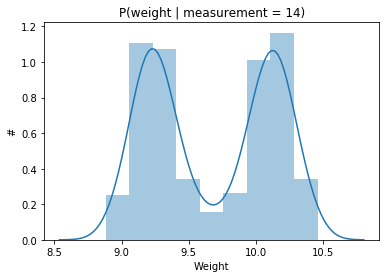

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

x = mcmc.get_samples()['weight']
sns.distplot(x)

plt.title("P(weight | measurement = 14)")
plt.xlabel("Weight")
plt.ylabel("#")

### Posterior predictive checking

## References
- [tutorial on deep probabilistic modeling](https://bookdown.org/robertness/causalml/docs/tutorial-on-deep-probabilitic-modeling-with-pyro.html)